# Automating gradient computation with Tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

In [2]:
def plot_img_from_url(url):
    from PIL import Image
    import cStringIO
    import urllib2
    im = Image.open(cStringIO.StringIO(urllib2.urlopen(url).read()))
    plt.imshow(im, origin='upper')
    plt.axis('off')
    
plot_img_from_url('http://1u88jj3r4db2x4txp44yqfj1.wpengine.netdna-cdn.com/wp-content/uploads/2015/06/automation.jpg')

ImportError: No module named 'cStringIO'

## Least squares

Let's generate some data corresponding to a linear regression problem.

In [3]:
n_samples = 1024
x = np.random.normal(0.0, 0.5, n_samples)
y = 2.5 * x + 2.25 + np.random.normal(0.0, 0.05, n_samples)

## Gradient Descent

As in tutorial 1, we are about to solve the estimation of a * x + b minimizing the squared loss of error with respect to y.

This time however, we are going to build the flow computations linking the data (observatoins of x and y) to the loss and let Tensorflow compute the corresponding loss gradient automatically.

## In this tutorial, an in this tutorial only, we will mimic the usual matematical notation of variables in upper case and their realization in lower case.

### Placeholders:

The first thing to build is the pair of buckets that will hold the data for x and the data for y. At a given step of our stochastic gradient descent, we will only take batch_size elements into account.

In [4]:
# Let's build a placeholder for the regressor:
X = tf.placeholder(shape=(None, 1), dtype=tf.float32)
# This is ready to welcome an numpy array of the same shape
# when we choose to assign value to the placholder.

# Let's do the same thing for the predicted variable:
Y = tf.placeholder(shape=(None, 1), dtype=tf.float32)

# A shape of None is adaptive and this dimension corresponds to the size of the batch
# We may want to change the size of the batch of data without having to re-instantiate
# the placeholders.

### Variables:

In the linear regression model we consider there are only two variables: the slope A and the offset B. Let's instantiate them and apply the model to the regressor X.

In [5]:
with tf.variable_scope('linear_prediction'):
    shape = [] # Shape [] means that we're using a scalar variable
    A = tf.Variable(tf.zeros(shape)) 
    B = tf.Variable(tf.zeros(shape))

def build_linear_predictor(X):
    return A * X + B

Y_PREDICTED = build_linear_predictor(X)

### Loss:

Now let's create a loss function encouraging the predicted value for Y to be close to the observations.

In [6]:
LOSS = tf.nn.l2_loss(Y_PREDICTED - Y)

### Computing a gradient:

Tensorflow is a symbol to symbol automated differentiation engine. Before we can evaluate the gradient for LOSS, we need to instantiate it.

In [7]:
GRADIENT = tf.gradients(LOSS, [A, B])

### Creating a session:

Now that we have created the symbols of the computation flow, including the gradient which is our quantity of interest here, we need to create a session that will enable the computation of numerical quantities such as the value of LOSS for a particular choice of input for X and Y.

A session also keeps in memory the state of variables which we will update as we improve our model.

In [8]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Evaluating a quantity:

We can now ask the session to evaluate any tensor we created. What we need to do however is to create a feed_dict which matches each placeholder with the data we use for our computation.

Let's just start by computing the loss corresponding to the current values of A and B with the entire dataset.

In [9]:
tot_loss = sess.run(LOSS, feed_dict={X: np.atleast_2d(x).T,
                                     Y: np.atleast_2d(y).T})

print(tot_loss)

3505.56


We can also compute the corresponding value for the gradient of the loss we created earlier

In [10]:
loss_grad = sess.run(GRADIENT, feed_dict={X: np.atleast_2d(x).T,
                                          Y: np.atleast_2d(y).T})

print(loss_grad)

[-683.01587, -2356.8901]


And now we can implement gradient descent if we update the values of the variables A and B using the assign operation.

In [11]:
learning_rate = 1e-4

print('Value of A: %.2f, value of B: %.2f:' % (sess.run(A), sess.run(B)))

sess.run(A.assign(A - learning_rate * loss_grad[0]))
sess.run(B.assign(B - learning_rate * loss_grad[1]))

print('Updated value A: %.2f, updated value of B: %.2f:' % (sess.run(A), sess.run(B)))

Value of A: 0.00, value of B: 0.00:
Updated value A: 0.07, updated value of B: 0.24:


If our learning rate is good, we should have a lower loss now if we compute it for updated values of A and B.

In [12]:
tot_loss = sess.run(LOSS, feed_dict={X: np.atleast_2d(x).T,
                                     Y: np.atleast_2d(y).T})

print(tot_loss)

2932.8


## Gradient descent, without having to give the gradient as input!

Let's now code again a gradient descent algorithm but this time using Tensorflow's automated differentiation.

### YOUR ANSWER HERE

In [13]:
def gradient_descent(tf_session, learning_rate, 
                     LOSS_FCT, VARIABLE_LIST,
                     feed_dict,
                     precision=1e-4, MAX_STEPS=1000):
    #    Here we are using all the data set
    #    Feed_dict remains constant
    #
    #    Your code here
    #
    
    #return optimum_variable_values, n_steps, trajectory, losses
    
    #
    #    Answer
    #
    # Let's first instantiate a gradient
    LOSS_GRAD = tf.gradients(LOSS_FCT, VARIABLE_LIST)
    
    old_loss = tf_session.run(LOSS_FCT, feed_dict=feed_dict)
    converged = False
    
    n_steps = 0
    trajectory = [tf_session.run(VARIABLE_LIST)]
    losses = []
    
    while not converged:
        n_steps += 1
        
        gradient = tf_session.run(LOSS_GRAD, feed_dict=feed_dict)
        
        for i, VARIABLE in enumerate(VARIABLE_LIST):
            tf_session.run(VARIABLE.assign(VARIABLE - learning_rate * gradient[i]))
            
        new_loss = tf_session.run(LOSS_FCT, feed_dict=feed_dict)
        converged = np.sum(np.array(gradient)**2) < precision * (1 + np.abs(new_loss))
        
        old_loss = new_loss
        
        trajectory.append(tf_session.run(VARIABLE_LIST))
        losses.append(old_loss)
        
        if n_steps > MAX_STEPS:
            print('Warning: gradient descent did not converge')
            break
    
    return trajectory[-1], n_steps, trajectory, losses

Let's check what the new algorithm gives (warning, this can take a few minutes to run):

Optimum found (2.500, 2.249) in 414 steps of Gradient Descent.


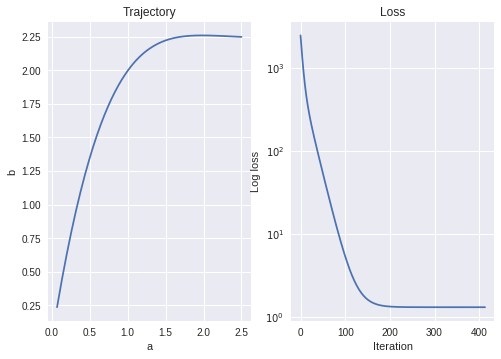

In [14]:
feed_dict={X: np.atleast_2d(x).T, Y: np.atleast_2d(y).T}

(a_opt, b_opt), n_steps, trajectory, losses = gradient_descent(sess, 1e-4,
                                                               LOSS, [A, B],
                                                               feed_dict)
sess.close()

print('Optimum found (%.3f, %.3f) in %d steps of Gradient Descent.' % (a_opt, b_opt, n_steps))

plt.subplot(121)
plt.plot([param[0] for param in trajectory], [param[1] for param in trajectory])
plt.title('Trajectory')
plt.xlabel('a')
plt.ylabel('b')

plt.subplot(122)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Log loss')
plt.yscale('log')

plt.show()

# Solving new machine learning problems quickly

One of the key perks of automated differentiation is that we can solve any other optimization problem as long as we are able to instantiate a loss function for it.

Let's take for instance a classification data set and solve the corresponding problem with logistic regression.

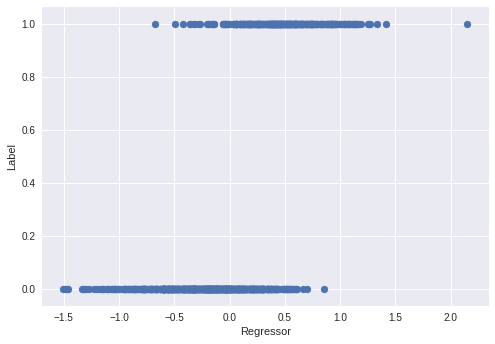

In [15]:
n_samples = 1024
x = np.random.normal(0.0, 0.5, n_samples)
pr = 1.0 / (1.0 + np.exp(-5.5 * x + 1.5))

y = np.random.binomial(1, pr, n_samples)

plt.scatter(x, y)
plt.xlabel('Regressor')
plt.ylabel('Label')
plt.show()

## Building a new model

To build a new model predicting Y based on X, we first build a logit layer trying to capture the linear dependency x -> -5.5 * x + 1.5.

We will choose to encode each label as a single integer and not as a one_hot vectors.

### YOUR ANSWER HERE

First, take care of the data and prepare placeholders for it.

In [16]:
## Create a placeholder for the variable X
#
#    Your code here
#

#
#    Solution
#
X = tf.placeholder(dtype=tf.float32, shape=[None, 1])

## Create a placeholder for the variable Y
#
#    Your code here
#

#
#    Solution
#
Y = tf.placeholder(dtype=tf.int32, shape=[None])

After that, start building a logit model based on X.

In [17]:
# Create variables that create a linear model with offset with X as a regressor.
#
#   Your code here
#

#
#    Solution
#
with tf.variable_scope('logit'):
    A = tf.Variable(tf.truncated_normal([1, 2]))
    B = tf.Variable(tf.truncated_normal([2]))

def build_logit(X):
    return tf.matmul(X, A) + B

LOGIT = build_logit(X)

Finally, instantiate a loss that will compute a cross-entropy loss on top of a softmax layer.
https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits
https://www.tensorflow.org/api_docs/python/tf/reduce_mean

In [18]:
# Create a LOSS function linking the actual labels in Y to the logit layer
#
# Your code here
#

#
# Solution
#
LOSS = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=LOGIT))

Although the gradient descent operates on the loss (and for now we don't split the data in train / test sets), the cross entropy loss score is not very readible. It is generally better to check at the same time the accuracy of the classifier based on the logits.

In [19]:
# Create an ACCURACY tensor
#
# Your code here
#

#
# Solution
#
ACCURACY = tf.reduce_mean(tf.cast(tf.nn.in_top_k(LOGIT, Y, 1), tf.float32))

Now lets slighy modify our gradient function so as to keep track of the values for the accuarcy.
To simplify the stopping criterion we now stop after MAX_STEPS steps of gradient descent.

In [23]:
def gradient_descent_with_eval(tf_session, learning_rate, 
                               LOSS_FCT, VARIABLE_LIST, EVAL_FCT,
                               feed_dict,
                               MAX_STEPS=200):
    #    Here we are using all the data set
    #    Feed_dict remains constant
    #
    #    Your code here
    #
    
    #return optimum_variable_values, trajectory, losses, accuracies
    
    #
    #    Answer
    #
    # Let's first instantiate a gradient
    LOSS_GRAD = tf.gradients(LOSS_FCT, VARIABLE_LIST)
    
    (old_loss, old_accuracy) = tf_session.run((LOSS_FCT, EVAL_FCT), feed_dict=feed_dict)
    converged = False
    
    trajectory = [tf_session.run(VARIABLE_LIST)]
    losses = []
    accuracies = []
    
    for step in range(MAX_STEPS):
        
        gradient = tf_session.run(LOSS_GRAD, feed_dict=feed_dict)
        
        for i, VARIABLE in enumerate(VARIABLE_LIST):
            tf_session.run(VARIABLE.assign(VARIABLE - learning_rate * gradient[i]))
            
        (new_loss, new_accuracy) = tf_session.run((LOSS_FCT, EVAL_FCT), feed_dict=feed_dict)
        
        old_loss = new_loss
        old_accuracy = new_accuracy
        
        trajectory.append(tf_session.run(VARIABLE_LIST))
        losses.append(old_loss)
        accuracies.append(old_accuracy)
    
    return trajectory[-1], trajectory, losses, accuracies

And run it on the new data set.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Optimum found in 414 steps of Gradient Descent.


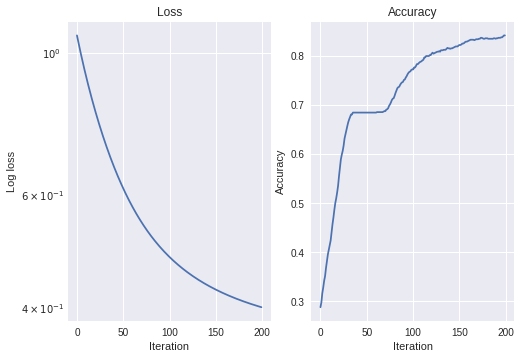

In [24]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

feed_dict={X: np.atleast_2d(x).T, Y: np.asarray(y, dtype=np.int32)}

_, trajectory, losses, accuracies = gradient_descent_with_eval(sess, 1e-1,
                                                               LOSS, [A, B], ACCURACY,
                                                               feed_dict)
sess.close()

print('Optimum found in %d steps of Gradient Descent.' % n_steps)

plt.subplot(121)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Log loss')
plt.yscale('log')

plt.subplot(122)
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.show()

### YOUR ANSWERS HERE

a) What do notice about the run-time?

### Solution:

a) It's slow... and we waste a lot of time computing early iterations for which we do not really need a precise estimate of the gradient.

# Automated differentiation for Stochastic Gradient Descent

Although it makes our life slightly easier because we do not have to compute gradients, automated differentiation has another perk: it can compute the gradient of the loss with respect to the model parameters as we choose different parts of our dataset to compute the loss.

Namely, we can now directly change what we assign in the placholders by controlling our feed_dict and run SGD for a certain batch_size (the number of elements we consider simultanously).

SGD is particularly helpful as it can speed up the training as we do not waste the time taken by looking at all the dataset in the early steps of the descent where our parameters are rubish anyway.

### YOUR ANSWER HERE

In [25]:
# Write a function that returns batch_size samples of (x, y) pairs chosen from the logistic regression data set.
# Don't forget to shuffle your data first.
#
# Your code here for the shuffling
#

#
# Solution
#
permutation = np.random.choice(np.arange(n_samples), n_samples)
x = x[permutation]
y = y[permutation]

def get_next_batch(batch_size, offset):
    #
    # Your code here that builds a batch of samples
    #
    
    #
    # Solution
    #
    selection = np.arange(offset, offset + batch_size) % n_samples
    return x[selection], y[selection]

Now, we have all the ingredients we need to code SGD on top of tensorflow.

In this tutorial we will only evaluate the accuracy on the batch we are computing the gradient with.

However, it is better to evaluate the accuracy on an independent test set that comprises of many more samples than there are in a single batch.

In [29]:
def stochastic_gradient_descent(tf_session, learning_rate, batch_size, 
                                LOSS_FCT, VARIABLE_LIST, EVAL_FCT,
                                next_batch_fct,
                                MAX_STEPS=200):
    #
    #    next_batch_fct takes batch_size and offset as argument and returns two numpy arrays, one for x, one for y.
    #
    #    Your code here
    #
    
    #return optimum_variable_values, trajectory, losses, accuracies
    
    #
    #    Answer
    #
    # Let's first instantiate a gradient
    LOSS_GRAD = tf.gradients(LOSS_FCT, VARIABLE_LIST)
    
    x_samples, y_samples = next_batch_fct(0, batch_size)
    feed_dict={X: np.atleast_2d(x_samples).T, Y: np.asarray(y_samples, dtype=np.int32)}
    (old_loss, old_accuracy) = tf_session.run((LOSS_FCT, EVAL_FCT), feed_dict=feed_dict)
    converged = False
    
    trajectory = [tf_session.run(VARIABLE_LIST)]
    losses = []
    accuracies = []
    
    for step in range(MAX_STEPS):
        x_samples, y_samples = next_batch_fct(step, batch_size)
        feed_dict={X: np.atleast_2d(x_samples).T, Y: np.asarray(y_samples, dtype=np.int32)}
        
        gradient = tf_session.run(LOSS_GRAD, feed_dict=feed_dict)
        
        for i, VARIABLE in enumerate(VARIABLE_LIST):
            tf_session.run(VARIABLE.assign(VARIABLE - learning_rate * gradient[i]))
            
        (new_loss, new_accuracy) = tf_session.run((LOSS_FCT, EVAL_FCT), feed_dict=feed_dict)
        
        old_loss = new_loss
        old_accuracy = new_accuracy
        
        trajectory.append(tf_session.run(VARIABLE_LIST))
        losses.append(old_loss)
        accuracies.append(old_accuracy)
        
    return trajectory[-1], trajectory, losses, accuracies

And we can run this algorithm to solve our logistic regression.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Optimum found in 414 steps of Gradient Descent.


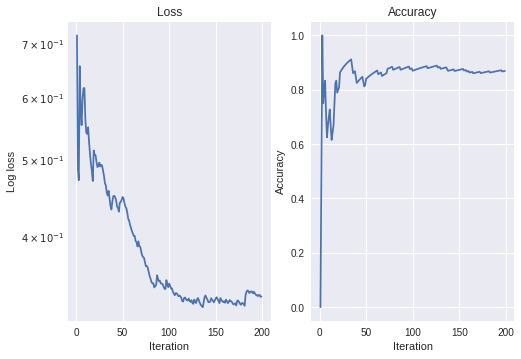

In [30]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

_, trajectory, losses, accuracies = stochastic_gradient_descent(sess, 1e-1, 8,
                                                                LOSS, [A, B], ACCURACY,
                                                                get_next_batch)
sess.close()

print('Optimum found in %d steps of Gradient Descent.' % n_steps)

plt.subplot(121)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Log loss')
plt.yscale('log')

plt.subplot(122)
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.show()

Normally, this should run faster now, each iteration being faster.

### YOUR ANSWER HERE

a) Do we actually achieve faster training systematically?
b) We used a constant learning rate here, is this a good idea?

### Solution:

a) Each iteration is quicker but less exact, therefore there is a tradeoff here.
b) We should use a linear decaying learning rate that sums to infinity but has a finite sum of squares such as 1 / (1 + t).